In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
import sys
sys.path.append("..")  # Go up one directory level

from case import CASE

In [3]:
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.datasets import load_breast_cancer

data_x, data_y = load_veterans_lung_cancer()

In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data_x.select_dtypes('category'))
data_x_encoded = pd.concat([data_x.select_dtypes(exclude='category'), pd.DataFrame(enc.transform(data_x.select_dtypes('category')).toarray(),
                              columns=enc.get_feature_names_out())],axis=1)


In [5]:
# Set parameters for the CASE model
study_period = 3
period_type = 'year'

# Create an instance of the CASE class
case_model = CASE(
    study_period=study_period, 
    period_type=period_type
)

In [6]:
data_x_tr = data_x_encoded[:100]
data_y_tr = data_y[:100]
data_x_test = data_x_encoded[100:]
data_y_test = data_y[100:]

In [7]:
x_case_tr,y_case_tr = case_model.transform(data_x_tr, data_y_tr)
x_case_test,y_case_test = case_model.transform(data_x_test, data_y_test, is_test_data=True)

In [8]:
case_model.fit_classifier(x_case_tr,y_case_tr, RandomForestClassifier())

CASE(study_period=3)

In [9]:
pred_scores_tr = case_model.fitted_classifier.predict_proba(x_case_tr)[:,1]
survivals_tr_censored = case_model.inverse_transform(pred_scores_tr, is_test_data=False)
survivals_tr = case_model.predict_survival_function_for_censored_training_data(data_x_tr,survivals_tr_censored)

In [10]:
pred_scores_test = case_model.fitted_classifier.predict_proba(x_case_test)[:,1]
survivals_test = case_model.inverse_transform(pred_scores_test, is_test_data=True)

In [11]:
case_reg_data, case_reg_y = case_model.construct_case_regression_data(data_x_tr,survivals_tr,y = data_y_tr)
case_reg_data_test = case_model.construct_case_regression_data(data_x_test,survivals_test)

In [12]:
case_model.fit_regression(case_reg_data, case_reg_y, RandomForestRegressor())

CASE(study_period=3)

In [13]:
y_pred_tr = case_model.fitted_regressor.predict(case_reg_data)

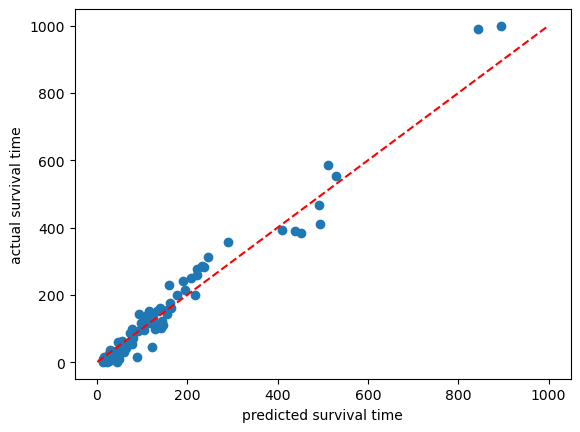

In [14]:
import matplotlib.pyplot as plt
plt.scatter(y_pred_tr,case_reg_y, label='Data points')

# Add a 45-degree line
min_val = min(min(y_pred_tr), min(case_reg_y))
max_val = max(max(y_pred_tr), max(case_reg_y))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect model')

plt.xlabel('predicted survival time')
plt.ylabel('actual survival time')
plt.show()